# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2023-2024, Q3
* Course homepage: https://brightspace.tudelft.nl/d2l/home/500969
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Maria de Neves de Fonseca (M.deNevesdeFonseca-1@student.tudelft.nl)
* (c) TU Delft, 2024

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [1]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "timothy van den Heuvel"
STUDENT_1_STUDENT_NUMBER = "5606403"
STUDENT_1_NETID = "timvandenheuve"
STUDENT_1_EMAIL = "t.j.vandenheuvel-1@student.tudelft.nl"

In [2]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions (also after the course is finished), and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for you that you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

# Task 3f.2 - Behaviour cloning of feedback torques as a function of the robot state (position and velocity) (15p)
**Authors:** Giovanni Franzese (G.Franzese@tudelft.nl), Lorenzo Lyons (L.Lyons@tudelft.nl), Maximilian Stölzle (M.W.Stolzle@tudelft.nl)

Here, we consider a dataset consisting of robot configurations and velocity as the inputs and proportional feedback torques as the labels. The only difference with the previous task is that we are now learning a policy that takes as input the angle configuration and the angle velocity of the joint and predicts the torque that is necessary to reproduce the behavior of following the ellipse. 


In [3]:
# Reloads the python files outside of this notebook automatically
%load_ext autoreload
%autoreload 2

# import all Python modules
from distutils.util import strtobool
from functools import partial
import gpytorch
from gpytorch.models import ApproximateGP
from IPython.display import display, HTML  # For animations in the notebook
from jax import config as jax_config

jax_config.update("jax_platform_name", "cpu")  # set default device to 'cpu'
jax_config.update("jax_enable_x64", True)  # double precision
from jax import Array, random
from jax import numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys
import torch
from torch.autograd.functional import jacobian
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm

from jax_double_pendulum.dynamics import dynamical_matrices
from jax_double_pendulum.motion_planning import (
    generate_ellipse_trajectory,
    ELLIPSE_PARAMS,
)
from jax_double_pendulum.robot_simulation import simulate_robot
from jax_double_pendulum.robot_parameters import ROBOT_PARAMS
from jax_double_pendulum.utils import normalize_link_angles
from jax_double_pendulum.visualization import animate_robot

from utils import (
    generate_training_data,
    plot_data,
)

# define boolean to check if the notebook is run for autograding
AUTOGRADING = strtobool(os.environ.get("AUTOGRADING", "false"))

# define folder where to save animations and plots
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)
# define the path to the folder that contains the datasets
datasets_dir = Path("datasets")

# import the feedforward gravity compensation controller from problem_2/controllers.ipynb
sys.path.insert(0, Path.cwd().parent / "problem_2")
from ipynb.fs.full.controllers import ctrl_ff_gravity_compensation

# define simulation settings
# define time steps
sim_dt = 0.005
sim_duration = 6.0
t_ts = sim_dt * jnp.arange(int(sim_duration / sim_dt))

# generate reference trajectory
traj_ts = generate_ellipse_trajectory(
    rp=ROBOT_PARAMS,
    t_ts=t_ts,
    **ELLIPSE_PARAMS,
)

## Task 3f.2.1 - Defining the GP model and setting up the training class (2p)
### Create a GP model that will take the joint angles and velocities as inputs and predict the feedback torques. (1p)
The robot angles have a periodicity of $2 \pi$, so they require a periodic kernel. In contrast, the velocity has no periodicity so we can use a generic kernel, for example, the RBF kernel or the Matern kernel.
To have two different kernels active in different dimensions, we can use the `Product` kernel and select which dimensions each kernel should act on.

**Cheat sheet:**

How to define the product of two kernels that are active on different dimensions for example, the first kernel is active on the first two dimensions, and the second kernel is active on the last two dimensions:
```python
kernel = gpytorch.kernels.Kernel(active_dims=[0, 1])) * gpytorch.kernels.Kernel(active_dims=[2, 3])
```

In [4]:
class MultitaskGPModel(ApproximateGP):
    def __init__(self, num_tasks, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_tasks])
        )

        variational_strategy = (
            gpytorch.variational.IndependentMultitaskVariationalStrategy(
                gpytorch.variational.VariationalStrategy(
                    self,
                    inducing_points,
                    variational_distribution,
                    learn_inducing_locations=True,
                ),
                num_tasks=num_tasks,
                task_dim=-1,
            )
        )

        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ZeroMean(batch_shape=torch.Size([num_tasks]))

        # self.covar_module = gpytorch.kernels.ScaleKernel(Periodic * Matern)))
        # YOUR CODE HERE
        self.covar_module = (
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.PeriodicKernel(active_dims=[0, 1])
            )
            * gpytorch.kernels.MaternKernel(active_dims=[2, 3])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Initialize the GP and the likelihood inside the `ControllerModel` class. (1p)

In [5]:
class ControllerModel:
    def __init__(self, X, Y, n_ind=100, batch_size=256):
        self.X = X
        self.Y = Y
        self.input_features = X.shape[1]
        self.output_dim = Y.shape[1]
        # number of inducing points
        unique_random_indices = torch.randperm(len(X))[:n_ind]
        inducing_points = X[unique_random_indices]
        self.inducing_points = inducing_points
        self.batch_size = batch_size
        self.is_cuda = False
        self.rmse_loss_vec = np.array([])

        # self.gp =
        # self.likelihood =
        # YOUR CODE HERE
        self.gp = MultitaskGPModel(num_tasks=self.output_dim, inducing_points=self.inducing_points)
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=self.output_dim)


    def to_cuda(self):
        if torch.cuda.is_available():
            self.gp = self.gp.cuda()
            self.likelihood = self.likelihood.cuda()
            self.X = self.X.cuda()
            self.Y = self.Y.cuda()
            self.is_cuda = True
        else:
            raise EnvironmentError("Cuda not available")

    def predict(self, x):
        if self.is_cuda:
            x = x.cuda()
        return self.likelihood(self.gp(x))

    def variance_fun(self, x):
        predictions = self.gp(x)
        return predictions.variance

    def derivative_variance(self, x):
        if self.is_cuda:
            x = x.cuda()
        jac = (
            jacobian(self.variance_fun, x)
            .detach()
            .view(self.output_dim, self.input_features)
        )  # shape: (num_outputs, num_features)
        return jac

    def train(self, num_epochs=400):
        self.gp = self.gp.double()
        self.likelihood = self.likelihood.double()
        self.X = self.X.double()
        self.Y = self.Y.double()
        self.train_dataset = TensorDataset(self.X, self.Y)
        self.train_loader = DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True
        )
        self.gp.train()
        self.likelihood.train()

        optimizer = torch.optim.Adam(
            [
                {"params": self.gp.parameters()},
                {"params": self.likelihood.parameters()},
            ],
            lr=0.01,
        )

        # Our loss object. We're using the VariationalELBO
        self.mll = gpytorch.mlls.VariationalELBO(
            self.likelihood, self.gp, num_data=self.Y.size(0)
        )

        # to plot the loss function
        self.rmse_loss_vec = np.zeros(num_epochs)

        for i in tqdm(range(num_epochs)):
            loss_sum = 0.0
            for x_batch, y_batch in self.train_loader:
                optimizer.zero_grad()
                output = self.gp(x_batch)
                loss = -self.mll(output, y_batch)
                loss.backward()
                optimizer.step()
                loss_sum += loss.detach().cpu()
            self.rmse_loss_vec[i] = (
                torch.sqrt(loss_sum / len(self.train_loader)).detach().item()
            )

    def plot_convergence(self, filename: str):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(self.rmse_loss_vec, label="loss")
        ax.set_xlabel("Epochs")
        ax.set_ylabel(r"Trainings RMSE for $\hat{\ddot{\theta}}$ [rad/s^2]")
        plt.savefig(str(outputs_dir / filename))

## Task 3f.2.2 - Load the trajectory-following dataset (0p)
Here, we load the dataset recorded in Task 3c.3. Namely, we extract the torques generated by the PD feedback controller when tracking the ellipse reference trajectory in conjunction with a gravity compensation feedforward term.

In [6]:
dataset_name = "trajectory_high_gains_grav_comp"
df = pd.read_csv(datasets_dir / f"{dataset_name}.csv")

input_columns = ["th_ts_1", "th_ts_2_rel", "th_d_ts_1", "th_d_ts_2_rel"]
output_columns = ["tau_fb_ts_1", "tau_fb_ts_2"]

# assemble tensors for training
X_feedback_torque, Y_feedback_torque = generate_training_data(
    df, input_columns, output_columns
)

## Task 3f.2.3 - Control the robot using the GP-based policy as the feedback controller while penalizing uncertainty (5p)
### Initialize the `ControllerModel` and train the GP (0p)

  0%|          | 0/400 [00:00<?, ?it/s]

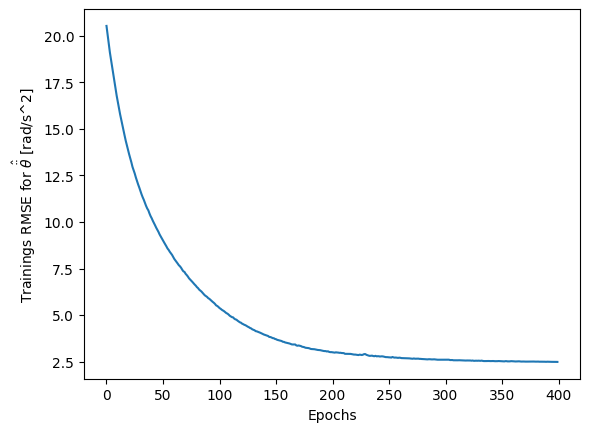

In [7]:
# set random seed
torch.manual_seed(42)

controller_model_feedback_torque = ControllerModel(X_feedback_torque, Y_feedback_torque)
controller_model_feedback_torque.train(num_epochs=400)

# plot convergence of training loss
controller_model_feedback_torque.plot_convergence(
    "task_3f-2-3_training_convergence_feedback_torques_state_input.pdf"
)

### Define the feedback control function that includes a variance minimization term (3p)
The total torque will consist of two components, one from the minimization of the uncertainty due to the joint angle and one from the minimization of the uncertainty due to the joint velocity. You need to tune the weight of each term to obtain a good performance.

In [9]:
th_0 = traj_ts["th_ts"][0]
th_d_0 = traj_ts["th_d_ts"][0]

# define feedforward gravity compensation controller
ctrl_ff = partial(
    ctrl_ff_gravity_compensation, partial(dynamical_matrices, ROBOT_PARAMS)
)


def feedback_ctrl_factory(controller_model: ControllerModel):
    # define the feedback function that implements the GP-based controller
    def ctrl_fb(th: Array, th_d: Array, th_des: Array, th_d_des: Array) -> Array:
        """
        Feedback controller that leverages the GP to compute the control action cloning the behavior of the PD controller
        Args:
            th: link angles. Shape: (2,)
            th_d: link velocities. Shape: (2,)
            th_des: desired link angles. Shape: (2,)
            th_d_des: desired link velocities. Shape: (2,)
        Returns:
            tau_fb: link torques computed by the GP-based feedback controller. Shape: (2,)
        """
        # compute the normalized joint angles (i.e., relative angles) from the link angles
        th_rel = normalize_link_angles(jnp.array([th[0], th[1] - th[0]]))
        # compute the joint velocities from the link velocities
        th_d_rel = jnp.array([th_d[0], th_d[1] - th_d[0]])

        # construct input for GP
        gp_input = torch.tensor(
            np.array(jnp.concatenate([th_rel, th_d_rel], axis=-1))
        ).unsqueeze(0)

        # perform the prediction with the GP
        # gp_output =
        # tau_gp_mean =
        # tau_gp_sigma =
        # YOUR CODE HERE
        gp_output = controller_model.predict(gp_input)
        tau_gp_mean = gp_output.mean.detach().numpy().squeeze()
        tau_gp_sigma = gp_output.variance.detach().numpy().squeeze()

        # derive the gradient of the variance
        # grad_gp_var =
        # YOUR CODE HERE
        grad_gp_var = controller_model.derivative_variance(gp_input).numpy().squeeze()


        # implement the control policy component that repels the system away from uncertainty
        # proportional to k_var, tau_gp_sigma, and grad_gp_var
        # k_var_postion=
        # k_var_velocity =
        # tau_var_repel_position =
        # tau_var_repel_velocity=
        # Hint: k_var_* should be in the range [0, 20]
        # YOUR CODE HERE
        k_var_position = 10.0  
        k_var_velocity = 10.0 
        tau_var_repel_position = -k_var_position * tau_gp_sigma * grad_gp_var[0]
        tau_var_repel_velocity = -k_var_velocity * tau_gp_sigma * grad_gp_var[1]

        # compute the total feedback torque
        tau_fb = tau_gp_mean + tau_var_repel_position + tau_var_repel_velocity

        

    return ctrl_fb


# simulate the robot together in a closed loop with the GP-based controller
print("starting simulation")
sim_ts = simulate_robot(
    ROBOT_PARAMS,
    t_ts=t_ts,
    th_0=th_0,
    th_d_0=th_d_0,
    ctrl_ff=ctrl_ff,
    ctrl_fb=feedback_ctrl_factory(controller_model_feedback_torque),
    jit_compile=False,
)
print("finished simulation")

if not AUTOGRADING:
    print("producing animation")
    ani = animate_robot(
        ROBOT_PARAMS,
        traj_ts=traj_ts,
        sim_ts=sim_ts,
        step_skip=5,
        show=False,
        filepath=str(
            outputs_dir
            / "task_3f-2-3_robot_animation_behavioural_cloning_feedback_torques_variance_minimization_state_input.mp4"
        ),
    )
    display(HTML(ani.to_html5_video()))

starting simulation


ValueError: operands could not be broadcast together with shapes (2,) (4,) 

### Discuss the results and motivate your reasoning (2p)

YOUR ANSWER HERE

## Task 3f.2.3 - Evaluate the GP-based feedback control policy for perturbed initial conditions (2p)

In [ ]:
# initialize PRNG key
rng = random.PRNGKey(seed=0)

# sample perturbation and define initial condition
rng, rng_sampling = random.split(rng, 2)
perturb = random.normal(rng_sampling, (4,))
th_0 = traj_ts["th_ts"][0] + 0.1 * perturb[:2]
th_d_0 = traj_ts["th_d_ts"][0] * 0.5 * perturb[-2:]

# simulate the robot together in a closed loop with the GP-based controller
print("starting simulation")
sim_ts = simulate_robot(
    ROBOT_PARAMS,
    t_ts=t_ts,
    th_0=th_0,
    th_d_0=th_d_0,
    ctrl_ff=ctrl_ff,
    ctrl_fb=feedback_ctrl_factory(controller_model_feedback_torque),
    jit_compile=False,
)
print("finished simulation")

if not AUTOGRADING:
    print("producing animation")
    ani = animate_robot(
        ROBOT_PARAMS,
        traj_ts=traj_ts,
        sim_ts=sim_ts,
        step_skip=5,
        show=False,
        filepath=str(
            outputs_dir
            / "task_3f-2-3_robot_animation_behavioural_cloning_feedback_torques_variance_minimization_state_input_perturbed_initial_condition.mp4"
        ),
    )
    display(HTML(ani.to_html5_video()))

### Comparison of control performance with Task 3f.1 (2p)
Discuss the results and motivate your reasoning by comparing the performance with Task 3f.1, where we controlled the robot as a function of the joint angles.

YOUR ANSWER HERE

## Task 3f.2.4 - Behavioural cloning of the total torque (1p)
To conclude this assignment, we will clone the total torque (instead of just the feedback torque), i.e., the sum of the feedback torque and the feedforward torque. The feedforward torque is computed as the gravity compensation torque. This is handy because, during control, we will not have to rely anymore on the gravity compensation term, and with that, we do not require any model knowledge during inference time.

In [ ]:
dataset_name = "trajectory_high_gains_grav_comp"
df = pd.read_csv(datasets_dir / f"{dataset_name}.csv")

input_columns = ["th_ts_1", "th_ts_2_rel", "th_d_ts_1", "th_d_ts_2_rel"]
output_columns = ["tau_ts_1", "tau_ts_2"]

# assemble tensors for training
X_total_torque, Y_total_torque = generate_training_data(
    df, input_columns, output_columns
)

In [ ]:
# set random seed
torch.manual_seed(42)

# controller_model_total_torque =
# YOUR CODE HERE
raise NotImplementedError()

# plot convergence of training loss
controller_model_total_torque.plot_convergence(
    "task_3f-2-4_training_convergence_total_torques_state_input.pdf"
)

### Closed-loop simulation with unperturbed initial conditions (0p)

In [ ]:
th_0 = traj_ts["th_ts"][0]
th_d_0 = traj_ts["th_d_ts"][0]
# simulate the robot together in a closed loop with the GP-based controller
print("starting simulation")
sim_ts = simulate_robot(
    ROBOT_PARAMS,
    t_ts=t_ts,
    th_0=th_0,
    th_d_0=th_d_0,
    # note that we are not anymore providing a feedforward control policy to the simulator
    ctrl_fb=feedback_ctrl_factory(controller_model_total_torque),
    jit_compile=False,
)
print("finished simulation")

if not AUTOGRADING:
    print("producing animation")
    ani = animate_robot(
        ROBOT_PARAMS,
        traj_ts=traj_ts,
        sim_ts=sim_ts,
        step_skip=5,
        show=False,
        filepath=str(
            outputs_dir
            / "task_3f-2-4_robot_animation_behavioural_cloning_total_torques_variance_minimization_state_input.mp4"
        ),
    )
    display(HTML(ani.to_html5_video()))

### Closed-loop simulation with perturbed initial conditions (0p)

In [ ]:
# initialize PRNG key
rng = random.PRNGKey(seed=0)

# sample perturbation and define initial condition
rng, rng_sampling = random.split(rng, 2)
perturb = random.normal(rng_sampling, (4,))
th_0 = traj_ts["th_ts"][0] + 0.1 * perturb[:2]
th_d_0 = traj_ts["th_d_ts"][0] * 0.5 * perturb[-2:]

# simulate the robot together in a closed loop with the GP-based controller
print("starting simulation")
sim_ts = simulate_robot(
    ROBOT_PARAMS,
    t_ts=t_ts,
    th_0=th_0,
    th_d_0=th_d_0,
    # note that we are not anymore providing a feedforward control policy to the simulator
    ctrl_fb=feedback_ctrl_factory(controller_model_total_torque),
    jit_compile=False,
)
print("finished simulation")

if not AUTOGRADING:
    print("producing animation")
    ani = animate_robot(
        ROBOT_PARAMS,
        traj_ts=traj_ts,
        sim_ts=sim_ts,
        step_skip=5,
        show=False,
        filepath=str(
            outputs_dir
            / "task_3f-2-4_robot_animation_behavioural_cloning_total_torques_variance_minimization_state_input_perturbed_initial_condition.mp4"
        ),
    )
    display(HTML(ani.to_html5_video()))

## Task 3f.2.5 - Design your own GP-based controller (Bonus, max. 5p)
Propose your own controller involving a Gaussian Process and evaluate it in a closed-loop with the robot simulator. You can use the code from the previous tasks as a starting point. You can also use the code from the previous tasks to generate your own dataset.
### Implement and simulate your controller (3p)

In [ ]:
# YOUR CODE GOES HERE
# YOUR CODE HERE
raise NotImplementedError()

### Discuss your GP-based controller and its performance (2p)

YOUR ANSWER HERE